# Quantum Error Correction Project
## Philippe Noël, Alaisha Sharma, Nicolas Weninger
### File #3: Error-corrected Deutsch-Josza Algorithm

In this file we use our results from the 3-qubits error correction and 9-qubits error correction codes to perform real error-corrected computations on one of the simplest known quantum algorithms: Deutsch-Josza. We first run Deutsch-Josza as a quantum simulation with and without error correction, which should give the same result. We then run Deutsch-Josza with and without error-correction on an IBM Q quantum computer and observe the behaviors of the system.

In [1]:
from qiskit import QuantumProgram
from qiskit.tools.visualization import plot_histogram
from qiskit.backends import local_backends, remote_backends
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qutip import *
from IPython.display import display, HTML
import Qconfig
import numpy as np
import matplotlib.pyplot as plt

As a reminder, Deutsch-Josza helps determine whether a boolean function f(x) is constant (returns the same value for all strings) or balanced (returns 1 for half the strings and 0 for the other half). Here is the quantum circuit for the algorithm with n qubits and 1 ancillary bit:

<img src="img/deutsch_josza_circuit.png">

In this specific instance of Deutsch-Josza, we define $U_{f}$, the oracle, as $\left|x\right>\left|y\right>\mapsto \left|x\right>\left|y \oplus f(x)\right>$. 


As we know, Deutsch-Josza can be used to test whether a function is balanced or not, and thus can be used with many different f(x). In the context of this experiment, we are mainly interested in the error-correction aspect, and thus have decided upon a very simple function:
\begin{equation}
f(x) = \left\{
\begin{array}{c}
1 \text{ if }x = 0 \\
0 \text{ if }x = 1.
\end{array}
\right.
\end{equation}

We have also settled for a 2-qubits Deutsch-Josza (in order to be able to run it on IBM Q, which cannot run too many qubits and as we have seen QEC scales the number of qubits required by a lot).

We first run this Deutsch-Josza on the Qiskit quantum simulator to see its theoretical behavior.

### 1. Run the theoretical simulation with a local quantum simulator as a control experiment.

Measurement after simulated Deutsch-Josza 2-qubits w/out errors:


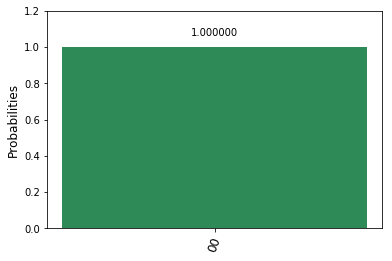

In [10]:
# run circuit without any errors on local quantum simulator
qp1 = QuantumProgram()

# 2 qubits Deutsch-Josza version
n = 2

# initialize quantum and classical registers
q1 = qp1.create_quantum_register("q1", n)
c1 = qp1.create_classical_register("c1", n) 

# theoretical Deutsch-Josza 2-qubits circuit
theoretical_DJ2 = qp1.create_circuit("theoretical_DJ2", [q1], [c1])

# add gates
# encode superposition
theoretical_DJ2.h(q1[0])
theoretical_DJ2.h(q1[1])
# U_f gate --> equivalent to CNOT that flips if control is 0 instead of 1
theoretical_DJ2.x(q1[0])
theoretical_DJ2.cx(q1[0], q1[1])
theoretical_DJ2.x(q1[0])
# decode superposition
theoretical_DJ2.h(q1[0])

# measurement operation
theoretical_DJ2.measure(q1[0], c1[0])

# execute circuit
results1 = qp1.execute("theoretical_DJ2")

# plot measurement results 
print("Measurement after simulated Deutsch-Josza 2-qubits w/out errors:")
plot_histogram(results1.get_counts("theoretical_DJ2"))

Running the previous simulation, but this time on an IBM Q quantum computer to see the real probabilities result:

### 2. Run the theoretical simulation with a real quantum computer to see the magnitude of errors.

In [11]:
# initialize our API with this program to run on IBM Q
qp1.set_api(Qconfig.APItoken, Qconfig.config["url"])

# check the remote and local quantum backends available to make
# sure that a quantum computer is available
# link to see devices architectures and their availability: https://quantumexperience.ng.bluemix.net/qx/devices
display(local_backends())
display(remote_backends())

/anaconda/lib/python3.6/site-packages/qiskit/_quantumprogram.py:707: DeprecationWarning: set_api() will be deprecated in upcoming versions (>0.5.0). Using the API object instead is recommended.
  "Using the API object instead is recommended.", DeprecationWarning)


['local_qasm_simulator',
 'local_clifford_simulator',
 'local_qiskit_simulator',
 'local_sympy_qasm_simulator',
 'local_sympy_unitary_simulator',
 'local_unitary_simulator']

['ibmqx_hpc_qasm_simulator',
 'ibmqx4',
 'ibmqx5',
 'ibmqx2',
 'ibmqx_qasm_simulator']

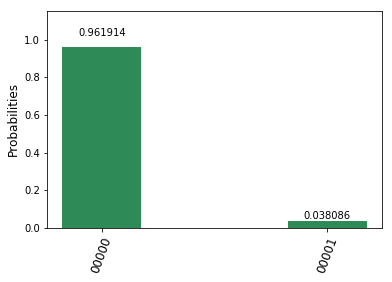

In [39]:
# set parameters
backend = 'ibmqx4' # this is a 5-qubits quantum computer   
circuits = ['theoretical_DJ2']  
shots = 1024           
max_credits = 3          
wait = 10   
timeout = 2400 
results_real1 = qp1.execute(circuits, backend, shots=shots, max_credits=max_credits, wait=wait, timeout=timeout)
plot_histogram(results_real1.get_counts("theoretical_DJ2"))

As we can see here, there is about 4% error rate (varies between 3.5% and 4.5%) of a bit flip from 0 to 1 when run on a real quantum computer (the IBM quantum computers are not error-correcting). We can now look at fixing this. A few words on how to interpret this diagram: Only the last qubit is |psi> state, so the state that matters here (the only that gets measured - refer to the circuit diagram). However, we ran our code on a 5-qubits IBM quantum computer, and thus all results are rendered as 5-qubits state, but we can disregard the first 3 since they were not involved in the algorithm and the fourth qubit since it does not get measured.

We will introduce the 3-qubits error correcting bit-flip code in our Deutsch-Josza process, for a total of 6 encoding qubits (since we run Deutsch-Josza on 2 qubits) and then use this error correction to better the results. As a reminder, here is a 3-qubits error-correction scheme:

<img src="img/9_qubits_single_qubit_encoding_circuit.png">

Under this error correction scheme, our Deutsch-Josza algorithm will take place in the "Error" position.

First, we will run our Deutsch-Josza theoretically, on the quantum simulator as in the first step, but this time with an induced bit flip error.

### 3. Run Deutsch-Josza w/ induced X-flip error & 3-qubits QEC code on the theoretical simulation.

Measurement after simulated Deutsch-Josza 2-qubits with 3-qubits QEC for X-flip error:


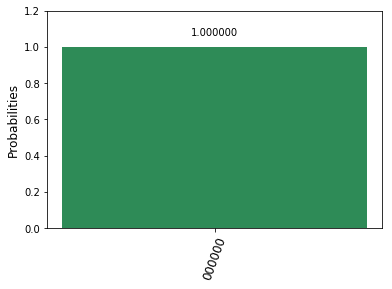

In [27]:
# run circuit with single bit-flip error & 3-qubits correction on local quantum simulator
qp2 = QuantumProgram()

# 6 qubits Deutsch-Josza for 2-qubits version (w/ 5 qubits for error correction for the |psi> state)
n = 6

# initialize quantum and classical registers
q2 = qp2.create_quantum_register("q2", n)
c2 = qp2.create_classical_register("c2", n) 

# create circuit --> theoretical Deutsch-Josza 2-qubits circuit w/ 3-qubits QEC
t3qec_DJ2 = qp2.create_circuit("t3qec_DJ2", [q2], [c2])

# add gates
# encode state
t3qec_DJ2.cx(q2[0], q2[1]) 
t3qec_DJ2.cx(q2[1], q2[2]) 

# we now introduce errors to our state. There will be none here as this
# is a simulation, but the error would come from the running of the 
# Deutsch-Josza algorithm qubit 0 and qubit 5 are our DJ qubits
# encode superposition
t3qec_DJ2.h(q2[0])
t3qec_DJ2.h(q2[5])
# U_f gate --> equivalent to CNOT that flips if control is 0 instead of 1
t3qec_DJ2.x(q2[0])
t3qec_DJ2.cx(q2[0], q2[5])
t3qec_DJ2.x(q2[0])
# decode superposition
t3qec_DJ2.h(q2[0])

# since there was no error since this is a simulation, we introduce a manual
# error to show that it would be corrected if this happened during Deutsch-Josza
t3qec_DJ2.x(q2[0])

# error detection component, looking for error on |psi>
t3qec_DJ2.cx(q2[0], q2[3]) 
t3qec_DJ2.cx(q2[1], q2[3]) 
t3qec_DJ2.cx(q2[0], q2[4]) 
t3qec_DJ2.cx(q2[2], q2[4]) 

# error correction component, correcting error if found
t3qec_DJ2.ccx(q2[3], q2[4], q2[0])
t3qec_DJ2.ccx(q2[3], q2[4], q2[1])
t3qec_DJ2.ccx(q2[3], q2[4], q2[2])
t3qec_DJ2.cx(q2[3], q2[1]) 
t3qec_DJ2.cx(q2[4], q2[2])

# measurement operation --> only care about |psi>
t3qec_DJ2.measure(q2[0], c2[0])

# execute circuit
results2 = qp2.execute("t3qec_DJ2")

# plot measurement results 
print("Measurement after simulated Deutsch-Josza 2-qubits with 3-qubits QEC for X-flip error:")
plot_histogram(results2.get_counts("t3qec_DJ2"))

As we can see, we get the same theoretical result as we were expecting and as we ran without the error correction. This makes sense, since there were no "real" error to correct here. We added a manual X-flip error to show that this 3-qubits error correction code can effectively correct through an actual algorithm. The more detailled proof of work of the whole 3-qubits code can be found in its own file.

Now that we have observed that it works on the simulator and effectively corrected the error, we run it on an actual quantum computer, hoping to see the magnitude of the error that we calcualted previously diminish.

### 4. Run Deutsch-Josza w/ induced X-flip error & 3-qubits QEC on a quantum computer to see the correction.

In [28]:
# initialize our API with this program to run on IBM Q
qp2.set_api(Qconfig.APItoken, Qconfig.config["url"])

# check the remote and local quantum backends available to make
# sure that a quantum computer is available
# link to see devices architectures and their availability: https://quantumexperience.ng.bluemix.net/qx/devices
display(local_backends())
display(remote_backends())

/anaconda/lib/python3.6/site-packages/qiskit/_quantumprogram.py:707: DeprecationWarning: set_api() will be deprecated in upcoming versions (>0.5.0). Using the API object instead is recommended.
  "Using the API object instead is recommended.", DeprecationWarning)


['local_qasm_simulator',
 'local_clifford_simulator',
 'local_qiskit_simulator',
 'local_sympy_qasm_simulator',
 'local_sympy_unitary_simulator',
 'local_unitary_simulator']

['ibmqx_hpc_qasm_simulator',
 'ibmqx4',
 'ibmqx5',
 'ibmqx2',
 'ibmqx_qasm_simulator']

We now need to re-create the qp2 program, but without the manually induced error, since the errors will exist on the IBM Q quantum computer.

Since we are here turning to a different quantum computer, we must analyze its architecture. The architectures for IBM Q computers are different depending on the number of qubits. The 5-qubits adopts the star architecture, while the 16-qubits adopts the lattice architecture, which requires us to perform some different mapping to run it (while on the simulator we did not have to worry about the mapping).

5-qubits architecture:

<img src="img/5_qubits_architecture.png">

16-qubits architecture:

<img src="img/16_qubits_architecture.png">

This is where we stumble across a problem. If we look at the 3-qubits code architecture from above, there are 3 CNOT gates involving |psi>. If you we look at Deutsch-Josza, there is also one CNOT gate, which means we need a qubit which can take in 4 controls, which does not exist on any of the 5-qubits or 16-qubits computers. 

One way to solve for this problem would be to use the IBM Q 20-qubits quantum computer, which has a much better lattice structure and can perform a stronger type of error correction. We briefly touch on this in our last notebook (refer to it for more detailled explanations).

<img src="img/modern_QEC_architecture.png">

As a result, it appears that we are unable to map the 3-qubits Deutsch-Josza to the available IBM Q quantum computers due to an architecture problem, and we are unable to run the 9-qubits code for the same reason (along with the larger requirement for qubits) as is explained below. We must thus settle for simulations here.

### 5. Run Deutsch-Josza w/ induced X-flip error & 9-qubits QEC code on the theoretical simulation.

As is explained in the nine_qubits_QEC_code file, the 9-qubits error correction code cannot be run on an actual quantum computer due to the lack of appropriate architecture and the size of the available computers. We nevertheless use it in an actual algorithm, mainly Deutsch-Josza, but on the quantum simulator. Refer to the 9-qubits file to see a thorough explanation of how the 9-qubits code works (we omit it here for cleanness).

We encode the state |psi> according to this scheme.

<img src="img/9_qubits_single_qubit_encoding_circuit.png">

We only need to encode one of the two Deutsch-Josza qubits according to the following scheme since only one will be measured, so we only care to error-correct on the measured state.

As per the 9-qubits file, we correct according to the following circuit. In this context, the error induced is actually coming from the running of Deutsch-Josza, which will therefore be placed in the Error (E) component).

<img src="img/9_qubits_total.jpg">

Measurement after simulated Deutsch-Josza 2-qubits through 9-qubits QEC:


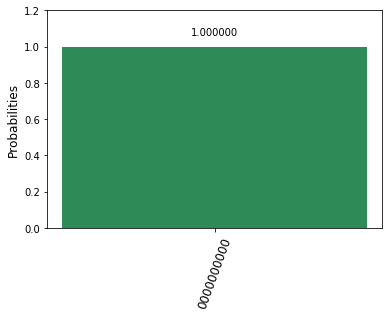

In [24]:
# run circuit with single bit-flip error & 9-qubits correction on local quantum simulator
# define program
qp3 = QuantumProgram()
n = 10  # number of qubits (9 to encode the first qubit & 1 for the second Deutsch-Josza qubit)
q3 = qp3.create_quantum_register("q3", n) # quantum register
c3 = qp3.create_classical_register("c3", n) # classical register

# create circuit --> theoretical 9-qubits error corrected Deutsch-Josza
t9qec_DJ2 = qp3.create_circuit("t9qec_DJ2", [q3], [c3])

# add gates
# creating our state |psi>
t9qec_DJ2.h(q3[0])

# encoding the state (refer to 9-qubits file)
t9qec_DJ2.cx(q3[0], q3[3])
t9qec_DJ2.cx(q3[0], q3[6])
t9qec_DJ2.h(q3[0])
t9qec_DJ2.h(q3[3])
t9qec_DJ2.h(q3[6])
t9qec_DJ2.cx(q3[0], q3[1])
t9qec_DJ2.cx(q3[0], q3[2])
t9qec_DJ2.cx(q3[3], q3[4])
t9qec_DJ2.cx(q3[3], q3[5])
t9qec_DJ2.cx(q3[6], q3[7])
t9qec_DJ2.cx(q3[6], q3[8])

# we now introduce errors to our state. There will be none here as this
# is a simulation, but the error would come from the running of the 
# Deutsch-Josza algorithm qubit 0 and qubit 9 are our DJ qubits
# encode superposition
t9qec_DJ2.h(q3[0])
t9qec_DJ2.h(q3[9])
# U_f gate --> equivalent to CNOT that flips if control is 0 instead of 1
t9qec_DJ2.x(q3[0])
t9qec_DJ2.cx(q3[0], q3[9])
t9qec_DJ2.x(q3[0])
# decode superposition
t9qec_DJ2.h(q3[0])

# since there was no error since this is a simulation, we introduce a manual
# error to show that it would be corrected if this happened during Deutsch-Josza
t9qec_DJ2.z(q3[0])
t9qec_DJ2.x(q3[0])

# we now perform the error correction
# X-error correction
t9qec_DJ2.cx(q3[0], q3[1])
t9qec_DJ2.cx(q3[0], q3[2])
t9qec_DJ2.ccx(q3[1], q3[2], q3[0])
t9qec_DJ2.cx(q3[3], q3[4])
t9qec_DJ2.cx(q3[3], q3[5])
t9qec_DJ2.ccx(q3[4], q3[5], q3[3])
t9qec_DJ2.cx(q3[6], q3[7])
t9qec_DJ2.cx(q3[6], q3[8])
t9qec_DJ2.ccx(q3[7], q3[8], q3[6])

# Z-error correction
t9qec_DJ2.h(q3[0])
t9qec_DJ2.h(q3[3])
t9qec_DJ2.h(q3[6])
t9qec_DJ2.cx(q3[0], q3[3])
t9qec_DJ2.cx(q3[0], q3[6])
t9qec_DJ2.ccx(q3[3], q3[6], q3[0])

# measurement operation
t9qec_DJ2.h(q3[0]) # decoding to appropriate measurement basis
t9qec_DJ2.measure(q3[0], c3[0])

# execute circuit
results3 = qp3.execute("t9qec_DJ2", shots=100) # less shots to speed up computations since 2^10 states

# plot measurement results 
print("Measurement after simulated Deutsch-Josza 2-qubits through 9-qubits QEC:")
plot_histogram(results3.get_counts("t9qec_DJ2"))

As we can see, we get the same theoretical result as we were expecting and as we ran without the error correction. This makes sense, since there were no "real" error to correct here. The proof that this code does indeed correct errors theoretically can be found on the 9-qubits file, here we mainly wanted to show that it could be ran through Deutsch-Josza on the similar error from the 9-qubits file, which shows that this type of error can effectively be corrected by on an actual algorithm.

As was mentioned in the 3-qubits file, the 3-qubits code is NOT a full quantum error-correcting code. The first true quantum error-correcting code is the 9-qubits code. Unfortunately, this is too large for us to be able to run it along with Deutsch-Josza on an actual quantum computer from IBM (we only have access to up to 16-qubits quantum computers). We thus have to settle for the 3-qubits partial error-correction code for this instance, but hope to be able to re-work on this project later when larger quantum computers will be available and run the simulation instance that we have shown above on an actual quantum computer.

The 20-qubits quantum computer could potentially provide the appropriate mapping to run it, but unfortunately is unavailable to us.

<img src="img/20_qubits_architecture.png">